In [ ]:
# COLAB: uncomment below to setup for Git
# !git clone https://github.com/C7082-2022/labs-cv-colab

In [ ]:
# COLAB: uncomment below to change directory
# cd labs-cv-colab/03-DL-basics

In [2]:
# setup for images
from IPython.display import Image

# Lab 05 Custom convnets

<br>

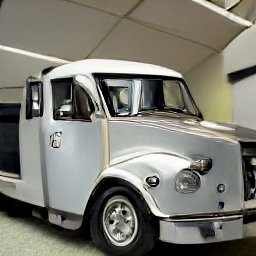

In [3]:
Image("img/craiyon-custom.jpg", width = 300)
# Craiyon.com "Custom Job" 


## 1 Objectives

Now that you've seen the layers a convnet uses to extract features, it's time to put them together and build a network of your own!

We have seen how convolutional networks perform **feature extraction** through three operations: **filter**, **detect**, and **condense**. A single round of feature extraction can only extract relatively simple features from an image, things like simple lines or contrasts. These are too simple to solve most classification problems. Instead, convnets will repeat this extraction over and over, so that the features become more complex and refined as they travel deeper into the network.


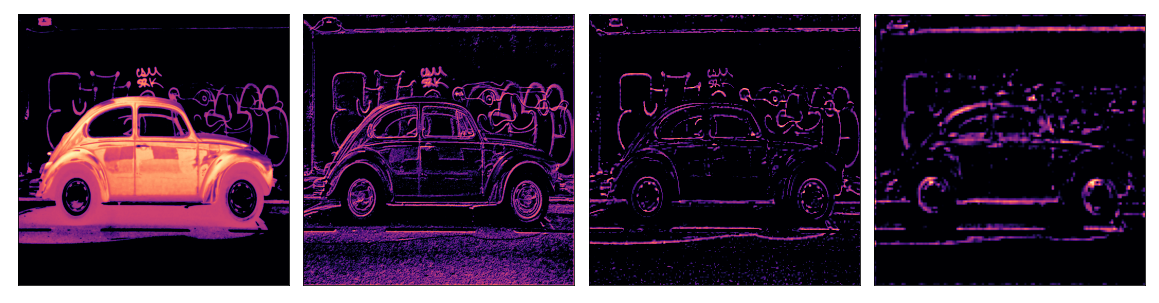

In [5]:
Image("img/5-1.png", width = 800)
# Features extracted from an image of a car, from simple to refined

## 2 Convolutional Blocks

It does this by passing them through long chains of **convolutional blocks** which perform this extraction.

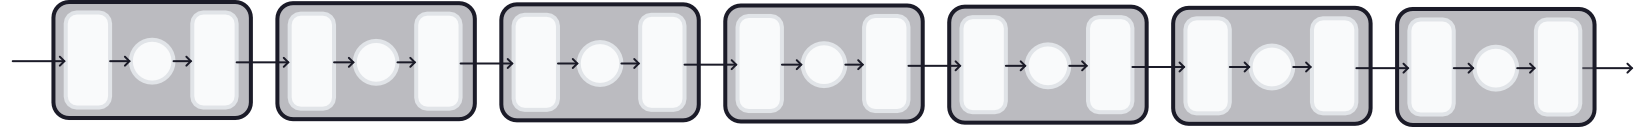

In [8]:
Image("img/5-2.png", width = 800)
# Extraction as a sequence of blocks

These convolutional blocks are stacks of `Conv2D` and `MaxPool2D` layers, whose role in feature extraction we learned about in the last few lessons.

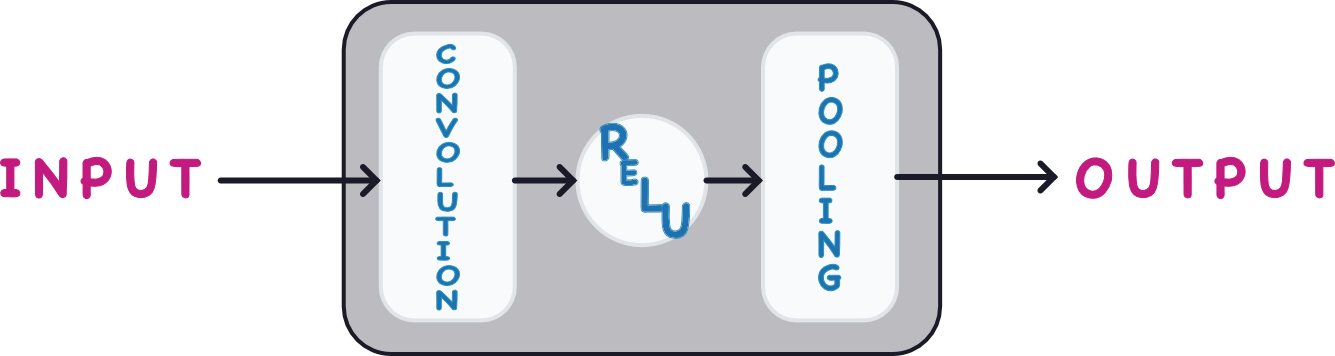

In [10]:
Image("img/5-3.png", width = 600)
# A kind of extraction block: convolution, ReLU, pooling

Each block represents a round of extraction, and by composing these blocks the convnet can combine and recombine the features produced, growing them and shaping them to better fit the problem at hand. The deep structure of modern convnets is what allows this sophisticated feature engineering and has been largely responsible for their superior performance.

## 3 Example - Design a Convnet

Let's see how to define a deep convolutional network capable of engineering complex features. In this example, we'll create a Keras `Sequence` model and then train it on our Cars dataset.

### 3.1 - Load Data ##

This hidden cell loads the data.

In [1]:

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'data/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'data/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


### 3.2 - Define Model

Here is a diagram of the model we'll use:

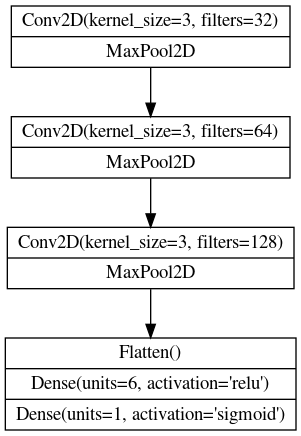

In [11]:
Image("img/5-4.png", width = 300)
# Diagram of a convolutional model

Now we'll define the model. See how our model consists of three blocks of `Conv2D` and `MaxPool2D` layers (the base) followed by a head of `Dense` layers. We can translate this diagram more or less directly into a Keras `Sequential` model just by filling in the appropriate parameters.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([

    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  input_shape=[128, 128, 3]),
    layers.MaxPool2D(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=6, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

Notice in this definition is how the number of filters doubled block-by-block: 32, 64, 128. This is a common pattern. Since the `MaxPool2D` layer is reducing the *size* of the feature maps, we can afford to increase the *quantity* we create.

### 3.3 - Train

We can train this model: compile it with an optimizer along with a loss and metric appropriate for binary classification.

In [3]:
# This one takes a while
import tensorflow as tf
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=40,
    verbose=1,
)


Epoch 1/40
80/80 [==============================] - 34s 417ms/step - loss: 0.6832 - binary_accuracy: 0.5697 - val_loss: 0.6779 - val_binary_accuracy: 0.5785
Epoch 2/40
80/80 [==============================] - 34s 423ms/step - loss: 0.6690 - binary_accuracy: 0.5785 - val_loss: 0.6618 - val_binary_accuracy: 0.5785
Epoch 3/40
80/80 [==============================] - 32s 401ms/step - loss: 0.6608 - binary_accuracy: 0.5787 - val_loss: 0.6566 - val_binary_accuracy: 0.5785
Epoch 4/40
80/80 [==============================] - 32s 397ms/step - loss: 0.6565 - binary_accuracy: 0.5878 - val_loss: 0.6518 - val_binary_accuracy: 0.6120
Epoch 5/40
80/80 [==============================] - 31s 390ms/step - loss: 0.6523 - binary_accuracy: 0.6226 - val_loss: 0.6485 - val_binary_accuracy: 0.6145
Epoch 6/40
80/80 [==============================] - 32s 402ms/step - loss: 0.6426 - binary_accuracy: 0.6320 - val_loss: 0.6518 - val_binary_accuracy: 0.5989
Epoch 7/40
80/80 [==============================] - 32s 39

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

This model is much smaller than the VGG16 model from Lesson 1 -- only 3 convolutional layers versus the 16 of VGG16. It was nevertheless able to fit this dataset fairly well. We might still be able to improve this simple model by adding more convolutional layers, hoping to create features better adapted to the dataset. This is what we'll try in the exercises.



## 4 Exercises

In these exercises, you'll build a custom convnet with performance competitive to the VGG16 model from Lesson 1.

Get started by running the code cell below.

In [1]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'data/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'data/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


**Design a Convnet**

Let's design a convolutional network with a block architecture like we saw in the tutorial. The model from the example had three blocks, each with a single convolutional layer. Its performance on the "Car or Truck" problem was okay, but far from what the pretrained VGG16 could achieve. It might be that our simple network lacks the ability to extract sufficiently complex features. We could try improving the model either by adding more blocks or by adding convolutions to the blocks we have.

Let's go with the second approach. We'll keep the three block structure, but increase the number of `Conv2D` layer in the second block to two, and in the third block to three.


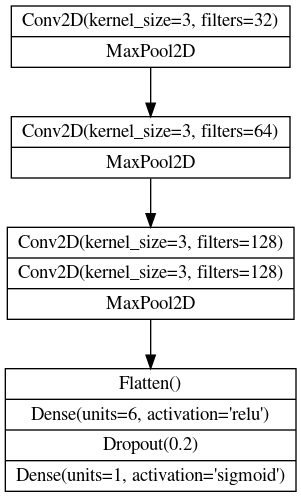

In [12]:
Image("img/5-5.png", width = 300)
# Diagram of a convolutional model

### 4.1 Define Model 

Given the diagram above, complete the model by defining the layers of the third block.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape=[128, 128, 3]),
    layers.MaxPool2D(),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    # YOUR CODE HERE
    # ____,

    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])


### 4.2 Compile

To prepare for training, compile the model with an appropriate loss and accuracy metric for the "Car or Truck" dataset.

In [3]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    # YOUR CODE HERE: Add loss and metric
)



In [4]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)


<br>

Finally, let's test the performance of this new model. First run this cell to fit the model to the training set.

In [ ]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

<br>

And now run the cell below to plot the loss and metric curves for this training run.

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

### 4.3 Train the Model #

How would you interpret these training curves? Did this model improve upon the model from the tutorial?